# Homework 4

### start by reading in the four starting images

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# unzip the faces.zip file into the folder containing Homework4.ipynb

# path to faces - need to reformat to work with your computer and operating system
path = './faces/'

# read in the four starting images
fisher   = plt.imread(path+'fisher.png')
stewart  = plt.imread(path+'stewart.png')
obama    = plt.imread(path+'obama.png')
cranston = plt.imread(path+'cranston.png')

# store the four faces in a list
# list with the 4 image matrices
face = [fisher, stewart, obama, cranston]
fnames = ['Fisher', 'Stewart', 'Obama', 'Cranston']
n_faces = len(face)

(fx, fy) = fisher.shape
flen = fx*fy
print('image size : ', fx, fy)

image size :  32 32


### view images

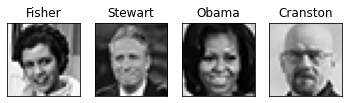

In [12]:
# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(face[i], 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()

### check image properties (values and types)

In [13]:
print('min pixel val of fisher : ', np.min(fisher))
print('max pixel val of fisher : ', np.max(fisher))
print('type in pixel : ', type(fisher[0,0]))

min pixel val of fisher :  0.0
max pixel val of fisher :  1.0
type in pixel :  <class 'numpy.float32'>


### center image around 0 and reshape into a 1D array rather than a 2D array

In [14]:
# preallocate numpy array to hold vectors of the four images
pats = np.zeros([n_faces, flen])

for i in range(n_faces):
    # reshape image
    p = face[i].reshape((flen,))
    
    # turn each image into a pattern ranging [-1 1]
    # Recentering about 0
    pats[i, :] = (p*2)-1
    
    # normalize each pattern to be unit length
    pats[i, :] = pats[i, :] / np.linalg.norm(pats[i, :])

### create noisy versions of each face to train network

In [15]:
import numpy.random as r

# create noisy versions of the image patterns 
n_train = 500

# amount of noise, width (e.g. std) of the normal distribution of noise added
noise_scale = 0.07

# preallocate training pattern array
train_pats = np.zeros([n_train*n_faces, flen]) #e.g. 2000 x 1024

idx = 0
# create noisy training patterns
# For each of the 500 variations, we will do the 4 faces we have
for j in range(n_train):
    for i in range(n_faces):
        
        # normal noise with 0 mean and stdev of 1, multiplied by noise_scale (0.07 std)
        unit_noise = r.randn(flen)*noise_scale
        # ^E.g. end up with a norm dist centered around 0, std of 0.07
        
        # add face with noise to produce training data
        train_pats[idx, :] = pats[i, :] + unit_noise
        
        # normalize activation to unit length
        train_pats[idx, :] = train_pats[idx, :] / np.linalg.norm(train_pats[idx, :])
        
        idx += 1

### display some of the noisy training patterns

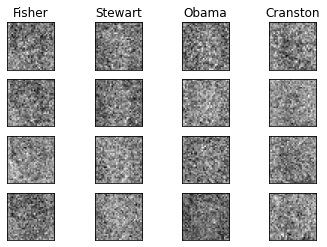

In [16]:
# you can play around with decreasing the noise level

for i in range(16):
    plt.subplot(4, 4, i+1)
    
    # reshape to square image
    this = train_pats[i, :].reshape([fx, fy])
    
    # convert back to [0 1] range
    this = (this+1)/2
    
    plt.imshow(this,'gray')
    
    plt.tick_params(axis='both',which='both',
          bottom=False,top=False,labelbottom=False,right=False,left=False,labelleft=False)   
    if i < 4:
        plt.title(fnames[i])

<hr>

<b>Q1.</b> Create a new 2000x4 numpy array called train_outs that has the “teacher” (output values you are training the network to reproduce) for each training pattern. For now, have the output of the correct answer equal to 1 and of the incorrect answers equal to 0.

Remember: You must not use hard-coded values. I have defined a lot of variables earlier in the code that you should use in your code.

In [17]:
### enter Q1 answer here ###

train_outs = np.zeros((n_train*n_faces, n_faces))
                      
for idx in range(n_train*n_faces):
    if idx == 0:
        # 0%anything=0, so we're just using it to initialize our vars
        count = 0
    elif idx%n_train==0:
        # e.g. move onto the next face
        count += 1
    train_outs[idx, count] = 1

In [18]:
# "Unit testing"

print(train_outs.shape)
for my_row in [0, 499, 500, 501, 999, 1000, 1001, 1499, 1500, 1999]:
    print(f"Row {my_row}: {train_outs[my_row,:]}")

(2000, 4)
Row 0: [1. 0. 0. 0.]
Row 499: [1. 0. 0. 0.]
Row 500: [0. 1. 0. 0.]
Row 501: [0. 1. 0. 0.]
Row 999: [0. 1. 0. 0.]
Row 1000: [0. 0. 1. 0.]
Row 1001: [0. 0. 1. 0.]
Row 1499: [0. 0. 1. 0.]
Row 1500: [0. 0. 0. 1.]
Row 1999: [0. 0. 0. 1.]


<hr>

<b>Q2.</b> Create a weight matrix with the appropriate dimensions. Initialize the weights in the matrix to random numbers drawn from a normal distribution. Normalize the weights so that the vector of weights contributing to the net input of any given output node has length equal to 1.

In [24]:
### enter Q2 answer here ###

# Note: assume linear activation function
rng = np.random.default_rng(12345)
W = rng.random((n_faces*n_train, fx*fy))  # 2000, 1024

# Now normalize the weights so that they sum to 1
def normalize_vector(W):
    for row_idx, row in enumerate(W):
        running_sum = 0
        for val in row:
            running_sum += val
        for val_idx, val in enumerate(row):
            W[row_idx, val_idx] = val / running_sum
    return W

W = normalize_vector(W)

In [25]:
# "Unit testing"

from math import isclose

print(W.shape)
print(W[0,:])
assert isclose(sum(W[0,:]), 1)

(2000, 1024)
[0.0004537  0.00063216 0.00159132 ... 0.00071693 0.0015217  0.00117544]


<hr>

<b>Q3.</b> Train the network using Oja’s rule. As described in class, tor each of the 2000 patterns, the change in weight $Δw_{ij}$ between input node $i_{i}$ and output node $o_{j}$ is given by

$Δw_{ij} = λ \, i_{i} \, o_{j}$

where λ is the learning rate (assume λ = .01). If you stopped here, this would be Hebbian learning. For Oja’s rule, you will need to normalize the weights after updating the weights for each training pattern such that the vector of weights contributing to the net input of any given output node has length equal to 1 (you don’t normalize after every individual Δ$w_{ij}$ update, but after you update all the weights in the network).

Obviously, to train the network, you will need to write code to train the network. In Homework 3, we gave you Keras code to do the training. For this assignment, you need to write that training code from scratch. This should be only a few lines of code. It’s not complicated.

You do not need to worry about making your code efficient (vectorizing and the like) – you can if you want, but you do not have to. Slow is fine, so long as it runs correctly. Note that it will take a while to train the network (several minutes, depending on the speed of your computer). 

In [26]:
print(train_outs.shape)
print(train_pats.shape)
print(this.shape)

(2000, 4)
(2000, 1024)
(32, 32)


In [39]:
print(W.shape)
print(W[0,:].shape)
print(W[0,1].shape)  #????

print("---------------------")

print(train_pats[0].shape)
print(train_outs[0,0].shape)
print(train_outs[0,0] + 1)

(2000, 1024)
(1024,)
()
---------------------
(1024,)
()
2.0


In [40]:
### enter Q3 answer here ###
# Have to do this by hand, cannot do this via keras/tf
# Step through all of the weights and adjust them as you go
# Do all the weight updates first for a given pattern
# oj is the teacher that is clamped onto the output
# You CANNOT do Hebbian learning with Keras/Tensorflow. 
# You need to implement Oja's rule (Hebbian learning + weight normalization) using basic Python code. 

lr = 0.01

for i in range(n_train*n_faces):  # Num patterns
    for j in range(fx*fy):  # Num pixels
        for k in range(n_faces):  # Num faces
            # Motivating line:
            # dw = lr*i[i]*o[j]  # What are i and o? Input/output nodes but what variables?

            # Updated code:
            dw = lr*train_pats[i]*train_outs[i,k]
            print(dw.shape)
            W[i,j,k] = W[i,j,k] + dw

# Given above
#dwij = lr*ii*oj
# The rule given in the slides for Oja's Rule
#dwij = lr*(ii*oj-oj**2*wij)
# Back to w
#wij = wij + dwij

# Normalize the weights


(1024,)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
""""""
u = 0.01
V = np.dot(self.weight , input_data.T)
i = 0

for inp in input_data:
    v = V[ : , i].reshape((n_features , 1))  #n_features is # of columns
    self.weight += (inp * v) - u * np.square(v) * self.weight
    i += 1
"""

In [ ]:
"""
def ojas(X, learning_rate = 0.1, iters = 100, features = 2):
    #create weights array initialized to random values
    w = np.random.rand(1,features)
    #w = np.array([0.5,0.5])
    #w = w.reshape(-1,1)

    # Init W
    W = np.copy(w)

    # Train - Fit
    for i in range(1,50):
        y = np.dot(X,w.T)
        delta_w = (learning_rate * np.multiply(y,X)) - (learning_rate * np.dot((np.square(y)),w))
        #delta_w = learning_rate * np.sum(np.multiply(y,X) - np.dot((np.square(y)),w))
        w = w + np.sum(delta_w)
    return w

def sangers(X, learning_rate = 0.1, iters = 100, features = 2):
    #create weights array initialized to random values
    w = np.random.rand(1,features)
    #w = np.array([0.5,0.5])
    #w = w.reshape(-1,1)
    W = np.copy(w)
    for i in range(1,50):
        y = np.dot(X,w.T)
        delta_w = learning_rate*(np.multiply(y,X) - np.dot(np.tril(np.outer(y,y.T)),w))
        w = w + np.sum(delta_w)
    return w
#TEST OJAS Rule
# Create Data
x = 0.5 * np.random.normal(size=10)
y = 0.5 * np.random.normal(size=10)
X = np.array([x , y]).T
X.shape

W = ojas(X)
print(W)
"""

<hr>

<b>Q4.</b> Visualize the weight going to each output unit of the network (like you did in Homework 3). You will need to produce four figures of “weight images”.

In [ ]:
## HW3 for reference

## Q3. Create "images" of the connection weight adapting the code used to display
## the actual digit images. There should be 10 weight images, an image for each
## set of weight connecting the input layer (784 inputs) to each output node.
## You will want to reshape the (784,1) vector of weights to a (28,28) image and
## display the result using imshow()

"""
def create_weight_images(W):
    w_rs = np.reshape(W, (28,28,10))
    fig = plt.figure()
    for i in range(10):
        plt.subplot(2,5,i+1)

        plt.imshow(w_rs[:,:,i], cmap='gray', interpolation='none')
        plt.title(f"{i}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

create_weight_images(W)
"""

In [ ]:
### enter Q4 answer here ###

"""
print(train_outs.shape)
print(train_pats.shape)
print(this.shape)
(2000, 4)
(2000, 1024)
(32, 32)
"""

def create_weight_images(W):
    w_rs = np.reshape(W, (fx,fy,train_pats.shape[0]))
    fig = plt.figure()
    for i in range(n_faces):
        plt.subplot(1,4,i+1)

        plt.imshow(w_rs[:,:,i], cmap='gray', interpolation='none')
        plt.title(f"{i}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

create_weight_images(W)

<hr>

<b>Q5.</b> Test your trained network. First, present each original image to the network (the four identities). Second, present a new noisy version (using the same level of noise used during training) of each of these images to the network. For each test image presented to the network, print out the correct answer and the answer produced by the network (winner-take-all).

Try creating a new set of four test images (one for each identity) with a higher level of noise that used during training that causes the network to make classification errors.

In [ ]:
### enter Q5 answer here ###

<hr>

<b>EXTRA CREDIT (2 point)</b>

See what happens when you change the coding for the output units from what was assumed above (the output of the correct answer equal to 1 and of the incorrect answers equal to 0) to a different coding of output units, with the output of the correct answer equal to 1 and the incorrect answers equal to -1). Retrain the network (like Q3), visualize the weights (like Q4), and test the network (like Q5).

Why does the visualization of the weights look different with this coding of output units from the one used in the main of the assignment? What is different about what is learned (and hence represented in the weights in the network) between the two ways of coding outputs? Add your written responses to a markdown cell in your assignment (an explanation is required to receive full extra credit).


In [ ]:
### enter extra credit answer here ###

# Instead of using one-hot (0s and 1s), use -1 and 1